In [62]:
# Import libraries

# Baiscs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

# Stock market 
import yfinance as yf

# ML 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import KerasRegressor
import tensorflow as tf

# Ensemble learning
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor


# Extras
from datetime import datetime
import json


In [63]:
def create_lstm_model(x_train, units=50, optimizer='adam', batch_size=32, epochs=25):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer with 1 unit for predicting 'Close'
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [64]:
def perform_grid_search_and_fit(x_train, y_train, param_grid, n_splits=5):
    # Wrap the Keras model so it can be used by scikit-learn GridSearchCV
    model = KerasRegressor(model=create_lstm_model(x_train), epochs=10, batch_size=32, verbose=1)  # Set verbose to 1 for more output

    # Create Time Series Split for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Create Grid Search
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)

    # Fit the grid search to the data
    print("Starting grid search...")
    grid_result = grid.fit(x_train, y_train)
    print("Grid search completed!")

    # Summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

    # Retrieve best hyperparameters
    best_batch_size = grid_result.best_params_['batch_size']
    best_optimizer = grid_result.best_params_['optimizer']
    best_epochs = grid_result.best_params_['epochs']

    # Build the final model with the best hyperparameters
    print("Building final model with best hyperparameters...")
    final_model = create_lstm_model(epochs=best_epochs, optimizer=best_optimizer, batch_size=best_batch_size)
    
    # Fit the final model
    final_model.fit(x_train, y_train)
    print("Final model training completed!")

    return final_model

In [65]:
# Fit a general min-max scaler

start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2022, 1, 1)

# AAPL, GGLE and NVDA
df1 = yf.download('AAPL', start=start_date, end=end_date)
df2 = yf.download('NFLX', start=start_date, end=end_date)
df3 = yf.download('NVDA', start=start_date, end=end_date)
df4 = yf.download('META', start=start_date, end=end_date)

# Combine 3 df into final_df (append them below each other)
final_df = pd.concat([df1, df2, df3, df4], axis=0)

scaler = MinMaxScaler(feature_range=(0, 1))
general_data = scaler.fit_transform(final_df[['Open', 'High', 'Low', 'Volume', 'Close']].values)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
# Load Data 1
ticker_symbol = 'AAPL'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2022, 1, 1)
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Prepare Data
scaled_data = scaler.transform(data[['Open', 'High', 'Low', 'Volume', 'Close']].values)


[*********************100%%**********************]  1 of 1 completed


In [12]:
prediction_days = 70

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, :])  # Using all four features
    y_train.append(scaled_data[x, 4])  # 'Close' is the fourth column (index 3)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

In [13]:
param_grid = {
    'batch_size': [32],  
    'epochs': [25],  
    'optimizer': ['adam'], 
}

final_model_1 = perform_grid_search_and_fit(x_train, y_train, param_grid)


Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/25
16/16 [==============================] - 3s 45ms/step - loss: 3.3768e-04
Epoch 2/25
16/16 [==============================] - 1s 45ms/step - loss: 7.9963e-05
Epoch 3/25
16/16 [==============================] - 1s 45ms/step - loss: 5.1578e-05
Epoch 4/25
16/16 [==============================] - 1s 39ms/step - loss: 3.7759e-05
Epoch 5/25
16/16 [==============================] - 1s 40ms/step - loss: 2.5017e-05
Epoch 6/25
16/16 [==============================] - 1s 41ms/step - loss: 2.3022e-05
Epoch 7/25
16/16 [==============================] - 1s 42ms/step - loss: 1.6969e-05
Epoch 8/25
16/16 [==============================] - 1s 41ms/step - loss: 1.8756e-05
Epoch 9/25
16/16 [==============================] - 1s 42ms/step - loss: 1.7279e-05
Epoch 10/25
16/16 [==============================] - 1s 42ms/step - loss: 1.4049e-05
Epoch 11/25
16/16 [==============================] - 1s 40ms/step - loss: 1.

In [20]:
# Prepare the data for the second stock code 

# Load Data
ticker_symbol = 'NVDA'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2022, 1, 1)
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Prepare Data
scaled_data_2 = scaler.transform(data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

[*********************100%%**********************]  1 of 1 completed


In [21]:
x_train_2 = []
y_train_2 = []

for x in range(prediction_days, len(scaled_data_2)):
    x_train_2.append(scaled_data_2[x - prediction_days:x, :])  # Using all four features
    y_train_2.append(scaled_data_2[x, 4])  # 'Close' is the fourth column (index 3)

x_train_2, y_train_2 = np.array(x_train_2), np.array(y_train_2)
x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1], x_train_2.shape[2]))

In [22]:
param_grid = {
    'batch_size': [32],  
    'epochs': [25],  
    'optimizer': ['adam'], 
}

final_model_2 = perform_grid_search_and_fit(x_train_2, y_train_2, param_grid)

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/25
16/16 [==============================] - 3s 40ms/step - loss: 5.8629e-05
Epoch 2/25
16/16 [==============================] - 1s 44ms/step - loss: 1.1865e-05
Epoch 3/25
16/16 [==============================] - 1s 43ms/step - loss: 7.0097e-06
Epoch 4/25
16/16 [==============================] - 1s 54ms/step - loss: 5.1105e-06
Epoch 5/25
16/16 [==============================] - 1s 38ms/step - loss: 4.7898e-06
Epoch 6/25
16/16 [==============================] - 1s 38ms/step - loss: 3.7840e-06
Epoch 7/25
16/16 [==============================] - 1s 40ms/step - loss: 3.1984e-06
Epoch 8/25
16/16 [==============================] - 1s 45ms/step - loss: 2.8207e-06
Epoch 9/25
16/16 [==============================] - 1s 39ms/step - loss: 2.3429e-06
Epoch 10/25
16/16 [==============================] - 1s 40ms/step - loss: 1.8688e-06
Epoch 11/25
16/16 [==============================] - 1s 40ms/step - loss: 1.

In [37]:
# Third stock code

# Load Data
ticker_symbol = 'META'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2022, 1, 1)
data3 = yf.download(ticker_symbol, start=start_date, end=end_date)

# Prepare Data
scaled_data_3 = scaler.fit_transform(data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

[*********************100%%**********************]  1 of 1 completed


In [38]:
x_train_3 = []
y_train_3 = []

for x in range(prediction_days, len(scaled_data_3)):
    x_train_3.append(scaled_data_3[x - prediction_days:x, :])  # Using all four features
    y_train_3.append(scaled_data_3[x, 4])  # 'Close' is the fourth column (index 3)

x_train_3, y_train_3 = np.array(x_train_3), np.array(y_train_3)
x_train_3 = np.reshape(x_train_3, (x_train_3.shape[0], x_train_3.shape[1], x_train_3.shape[2]))

In [39]:
param_grid = {
    'batch_size': [32],  
    'epochs': [25],  
    'optimizer': ['adam'], 
}

final_model_3 = perform_grid_search_and_fit(x_train_3, y_train_3, param_grid)

Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/25
16/16 [==============================] - 3s 44ms/step - loss: 1.4872e-04
Epoch 2/25
16/16 [==============================] - 1s 38ms/step - loss: 2.1771e-05
Epoch 3/25
16/16 [==============================] - 1s 40ms/step - loss: 1.2153e-05
Epoch 4/25
16/16 [==============================] - 1s 51ms/step - loss: 9.6643e-06
Epoch 5/25
16/16 [==============================] - 1s 45ms/step - loss: 8.0092e-06
Epoch 6/25
16/16 [==============================] - 1s 44ms/step - loss: 7.8445e-06
Epoch 7/25
16/16 [==============================] - 1s 54ms/step - loss: 6.7486e-06
Epoch 8/25
16/16 [==============================] - 1s 47ms/step - loss: 7.1529e-06
Epoch 9/25
16/16 [==============================] - 1s 43ms/step - loss: 6.1803e-06
Epoch 10/25
16/16 [==============================] - 1s 44ms/step - loss: 5.3734e-06
Epoch 11/25
16/16 [==============================] - 1s 40ms/step - loss: 5.

## Conduct ensemble learning

In [40]:
# get the average of 2 predictions 

predicted_stock_price_1 = final_model_1.predict(x_train)
predicted_stock_price_2 = final_model_2.predict(x_train_2)
predicted_stock_price_3 = final_model_3.predict(x_train_3)

# Average the predictions
predicted_stock_price = (predicted_stock_price_1 + predicted_stock_price_2 + predicted_stock_price_3) / 3


93/93 [==============================] - 1s 10ms/step


## Testing for the ensembled model

## Testing for the first 2 models 


In [58]:
# Update the end_date to today
end_date_today = dt.datetime.now()

# Retrieve data from the end_date until today
test_data = yf.download('NFLX', start=end_date, end=end_date_today)

# Scale the test data using the same scaler
scaled_test_data = scaler.transform(test_data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

# Create sequences for the test set
x_test = []
y_test = []

# Use the same prediction_days value as in the training data
for x in range(prediction_days, len(scaled_test_data)):
    x_test.append(scaled_test_data[x - prediction_days:x, :])
    y_test.append(scaled_test_data[x, 4])  # 'Close' is the fifth column (index 4)

x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the test set to match the LSTM model's input shape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


[*********************100%%**********************]  1 of 1 completed


In [59]:
# Predictions on the test set
y_pred_1 = final_model_1.predict(x_test)
y_pred_2 = final_model_2.predict(x_test)
y_pred_3 = final_model_3.predict(x_test)

# Inverse transform the scaled predictions and true values to the original scale
y_pred1_original = scaler.inverse_transform(np.concatenate((x_test[:, -1, :4], y_pred_1.reshape(-1, 1)), axis=1))[:, 4]
y_pred2_original = scaler.inverse_transform(np.concatenate((x_test[:, -1, :4], y_pred_2.reshape(-1, 1)), axis=1))[:, 4]
y_pred3_original = scaler.inverse_transform(np.concatenate((x_test[:, -1, :4], y_pred_3.reshape(-1, 1)), axis=1))[:, 4]
y_pred_original = (y_pred1_original + y_pred2_original + y_pred3_original ) / 3
# y_pred_original = y_pred1_original

y_test_original = scaler.inverse_transform(np.concatenate((x_test[:, -1, :4], y_test.reshape(-1, 1)), axis=1))[:, 4]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")


15/15 [==============================] - 0s 10ms/step
Mean Absolute Error (MAE): 42.15707896764594
Mean Squared Error (MSE): 3249.165113823621
R-squared (R2) Score: 0.7029502625421424


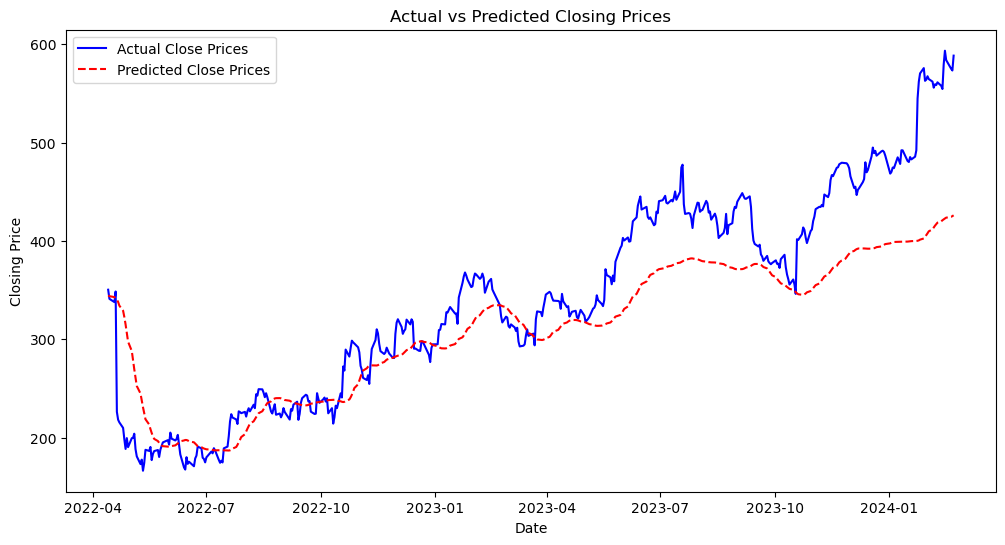

In [60]:
# Plot the actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[prediction_days:], y_test_original, label='Actual Close Prices', color='blue')
plt.plot(test_data.index[prediction_days:], y_pred_original, label='Predicted Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()